In [17]:
import xml.etree.ElementTree as ET
import pandas as pd

tree = ET.parse('dataset/annotations.xml')
root = tree.getroot()

data = []
for image in root.findall('image'):
    filename = image.get('name')[7:]
    for box in image.findall('box'):
        xmin = float(box.get('xtl'))
        ymin = float(box.get('ytl'))
        xmax = xmin + float(box.get('xbr'))
        ymax = ymin + float(box.get('ybr'))
        data.append([filename, xmin, ymin, xmax, ymax])

df = pd.DataFrame(data, columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax'])
df.head()


,filename,xmin,ymin,xmax,ymax
0,0.jpg,446.28,162.08,2157.44,2225.47
1,1.jpg,610.53,1274.55,2327.43,4021.36
2,10.jpg,707.24,955.50,2349.93,3409.10
3,11.jpg,274.90,379.11,1602.70,2380.91
4,12.jpg,940.76,785.40,2921.12,3091.57


In [18]:
import os

df['filepath'] = df['filename'].apply(lambda x: os.path.join('dataset/images', x))
df.head()

,filename,xmin,ymin,xmax,ymax,filepath
0,0.jpg,446.28,162.08,2157.44,2225.47,dataset/images\0.jpg
1,1.jpg,610.53,1274.55,2327.43,4021.36,dataset/images\1.jpg
2,10.jpg,707.24,955.50,2349.93,3409.10,dataset/images\10.jpg
3,11.jpg,274.90,379.11,1602.70,2380.91,dataset/images\11.jpg
4,12.jpg,940.76,785.40,2921.12,3091.57,dataset/images\12.jpg


In [19]:
import tensorflow as tf


img_size=(224,224)

def load_image_and_boxes(path,boxes):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)

    h=tf.shape(img)[0]
    w=tf.shape(img)[1]

    img=tf.image.resize(img,img_size)

    scale_x=tf.cast(img_size[1],tf.float32)/tf.cast(w,tf.float32)
    scale_y=tf.cast(img_size[0],tf.float32)/tf.cast(h,tf.float32)

    xmin=boxes[:,0]*scale_x
    ymin=boxes[:,1]*scale_y
    xmax=boxes[:,2]*scale_x
    ymax=boxes[:,3]*scale_y

    boxes = tf.stack([
        xmin / img_size[1],
        ymin / img_size[0],
        xmax / img_size[1],
        ymax / img_size[0]
    ], axis=-1)

    return img,boxes

paths=df['filepath'].unique()
records=[]

for path in paths:
    records.append((path,df[df['filepath']==path][['xmin','ymin','xmax','ymax']].values))

ds = tf.data.Dataset.from_generator(
    lambda: ((p,b) for p,b in records),
    output_signature=(
        tf.TensorSpec(shape=(),dtype=tf.string),
        tf.TensorSpec(shape=(None,4),dtype=tf.float32)
    )
)

ds=ds.map(lambda path,boxes:load_image_and_boxes(path,boxes))

In [20]:
base_model=tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False)
x=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(4,activation='sigmoid')(x)
model=tf.keras.Model(inputs=base_model.input,outputs=output)

In [21]:
model.compile(optimizer='adam', loss='mse')
model.fit(ds.batch(8), epochs=20)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - loss: 0.0344
Epoch 2/20


c:\Users\gayat\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - loss: 0.0195
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 856ms/step - loss: 0.0153
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 854ms/step - loss: 0.0141
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 829ms/step - loss: 0.0127
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 786ms/step - loss: 0.0125
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 790ms/step - loss: 0.0121
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 828ms/step - loss: 0.0119
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 902ms/step - loss: 0.0118
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 118s 10s/step - loss: 0.0119
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 894ms/step - loss: 0.0117
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 908ms/step - loss: 0.0116
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 908ms/step - loss: 0.0115
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 830ms/step - loss: 0.0115
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 903ms/step - loss: 0.0117
Epoch 16/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 689ms/step -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


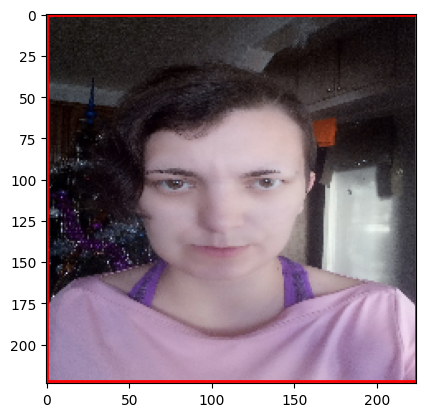

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Shuffle dataset and take 1 random item
sample_img, sample_boxes = next(iter(ds.shuffle(100)))

# Prepare for prediction
input_img = tf.expand_dims(sample_img, axis=0)
pred = model.predict(input_img)[0]

h, w = sample_img.shape[:2]
xmin, ymin, xmax, ymax = pred * [w, h, w, h]

# Visualize
fig, ax = plt.subplots(1)
ax.imshow(sample_img)

rect = patches.Rectangle(
    (xmin, ymin),
    xmax - xmin, ymax - ymin,
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)

plt.show()


In [ ]:
import cv2

cam=cv2.VideoCapture(0)
check,frame=cam.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
input_img = tf.expand_dims(tf.image.resize(frame,img_size), axis=0)
pred = model.predict(input_img)[0]
cam.release()
cv2.destroyAllWindows()

h, w = frame.shape[:2]
xmin, ymin, xmax, ymax = pred * [w, h, w, h]

# Visualize
fig, ax = plt.subplots(1)
ax.imshow(frame)

rect = patches.Rectangle(
    (xmin, ymin),
    xmax - xmin, ymax - ymin,
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)

plt.show()
